# Assignment 4 - Generative Adversarial Networks V1.0

## 1.0 Theorical Questions


-  Q1: Minimax loss in GANs and why it creates “competitive” training

GANs are framed as a **two-player minimax game** where the discriminator $D$ tries to correctly classify real vs. fake samples, while the generator $G$ tries to produce fake samples that **fool** $D$ (Dingari, n.d.; Goodfellow et al., 2014).040---Module-4---Generative-Adv… The classic objective is:
$$
\min_{G}\; \max_{D}\; V(D,G)=\mathbb{E}_{x\sim p_{\text{data}}}[\log D(x)] + \mathbb{E}_{z\sim p_z}[\log(1-D(G(z)))].
$$
This ensures competitive training because improving $D$ makes it harder for $G$ to succeed, forcing $G$ to generate more realistic samples; conversely, as $G$ improves, $D$ must refine its decision boundary to keep distinguishing real from fake (Dingari, n.d.).040---Module-4---Generative-Adv… In practice, training alternates updates to $D$ and $G$ so neither model “wins” too quickly, helping both improve together (Dingari, n.d.).040---Module-4---Generative-Adv…

------

-  Q2: Mode collapse—what it is, why it happens, and mitigation

**Mode collapse** happens when the generator produces **low-diversity outputs**, often repeating the same (or very similar) samples instead of covering the full variety (modes) of the real data distribution (Dingari, n.d.). A simple way to express it is that many latent inputs map to essentially the same output:
$$
G(z_1)\approx G(z_2)\approx \cdots \approx x^{*}\quad \text{for many different } z.
$$
Mode collapse can occur because the adversarial objective rewards $G$ for generating *any* samples that fool $D$, so $G$ may find a “shortcut” by concentrating probability mass on a small set of outputs that reliably trick $D$, especially under unstable dynamics when one network overpowers the other (Dingari, n.d.). Mitigations include stabilizing and diversity-promoting techniques such as **minibatch discrimination**, **batch normalization**, and using more stable objectives like **Wasserstein GAN (WGAN)**, which the course notes highlight as helping reduce instability and lowering the likelihood of mode collapse (Arjovsky et al., 2017; Dingari, n.d.; Salimans et al., 2016).

------

-  Q3: Role of the discriminator in adversarial training

The discriminator is the **learning signal provider**: it is trained as a binary classifier that outputs $D(x)\in[0,1]$, the estimated probability that input $x$ is real, and it learns by seeing both real samples and generator-produced fakes (Dingari, n.d.).040---Module-4---Generative-Adv… A standard discriminator loss is:
$$
\mathcal{L}_D
= -\mathbb{E}_{x\sim p_{\text{data}}}[\log D(x)]
\;-\;
\mathbb{E}_{z\sim p_z}[\log(1-D(G(z)))].
$$
During training, $D$ improves its ability to detect fake data, while $G$ updates using gradients that flow *through* $D$, improving generation specifically in directions that make fakes harder to detect (Dingari, n.d.; Goodfellow et al., 2014).040---Module-4---Generative-Adv… This adversarial loop—alternating updates to $D$ and $G$—creates the dynamic competition that drives GAN learning (Dingari, n.d.).040---Module-4---Generative-Adv…

------

-  Q4: How IS and FID evaluate GAN performance

**Inception Score (IS)** evaluates generated images using a pretrained classifier (Inception network). It rewards images that (1) yield **confident class predictions** $p(y|x)$ (suggesting sharp/recognizable samples) and (2) yield a **diverse** marginal label distribution $p(y)$ across many samples (Salimans et al., 2016). A common definition is:
$$
IS = \exp\left(\mathbb{E}_{x\sim p_g}\left[ D_{\mathrm{KL}}\big(p(y|x)\,\|\,p(y)\big)\right]\right).
$$
**Fréchet Inception Distance (FID)** compares the **feature distributions** of real vs. generated images (typically Inception features) by modeling each set as a Gaussian with mean $\mu$ and covariance $\Sigma$, then computing a distance between them; lower is better and indicates generated samples match real data statistics more closely (Heusel et al., 2017). The standard formula is:
$$
FID=\|\mu_r-\mu_g\|_2^2+\mathrm{Tr}\left(\Sigma_r+\Sigma_g-2(\Sigma_r\Sigma_g)^{1/2}\right).
$$
In short, IS focuses on classifier confidence + label diversity, while FID directly measures how close generated and real feature distributions are—often making FID more sensitive to both realism and mode coverage (Heusel et al., 2017; Salimans et al., 2016).

------

## References

Arjovsky, M., Chintala, S., & Bottou, L. (2017). *Wasserstein GAN*. In **Proceedings of the 34th International Conference on Machine Learning (ICML 2017)** (pp. 214–223). PMLR.

Dingari, N. C. (n.d.). *Module 4: Generative Adversarial Networks (GANs)* [Course handout]. DS552 – Generative AI.040---Module-4---Generative-Adv…

Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014). Generative adversarial nets. In **Advances in Neural Information Processing Systems** (Vol. 27).

Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). GANs trained by a two time-scale update rule converge to a local Nash equilibrium. In **Advances in Neural Information Processing Systems** (Vol. 30).

Salimans, T., Goodfellow, I., Zaremba, W., Cheung, V., Radford, A., & Chen, X. (2016). Improved techniques for training GANs. In **Advances in Neural Information Processing Systems** (Vol. 29).

## 2.0 Code Implementation

In [1]:
import os, certifi
os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
BUFFER_SIZE = 50000
BATCH_SIZE = 256
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 64
SAVE_EVERY = 10  # save images every 10 epochs
OUT_DIR = "gan_cifar10_samples"

os.makedirs(OUT_DIR, exist_ok=True)

In [2]:
history = {
    "g_loss": [],
    "d_loss": [],
    "d_real_prob": [],
    "d_fake_prob": [],
    "epoch_time": [],
}

def plot_history(history):
    import numpy as np
    import matplotlib.pyplot as plt

    epochs = np.arange(1, len(history["g_loss"]) + 1)

    # Plot losses
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, history["g_loss"], label="Generator loss")
    plt.plot(epochs, history["d_loss"], label="Discriminator loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAN Loss Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot discriminator confidence (probabilities)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, history["d_real_prob"], label="mean D(real) prob")
    plt.plot(epochs, history["d_fake_prob"], label="mean D(fake) prob")
    plt.axhline(0.5, linestyle="--", linewidth=1)
    plt.ylim(0, 1)
    plt.xlabel("Epoch")
    plt.ylabel("Mean sigmoid(logit)")
    plt.title("Discriminator Confidence Over Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot epoch time (optional)
    plt.figure(figsize=(8, 4))
    plt.plot(epochs, history["epoch_time"], label="seconds/epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Seconds")
    plt.title("Epoch Runtime")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [3]:
# -----------------------
# Data: CIFAR-10 (32x32x3)
# -----------------------
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype("float32")
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)   # keep batch size fixed for tf.function
    .prefetch(tf.data.AUTOTUNE)
)


2026-02-05 19:17:32.269580: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2026-02-05 19:17:32.269604: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2026-02-05 19:17:32.269610: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 53.76 GB
I0000 00:00:1770347852.269620 10406173 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1770347852.269635 10406173 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# -----------------------
# Generator (32x32x3) with EXTRA conv layers
# -----------------------
def make_generator_model():
    model = tf.keras.Sequential(name="Generator")

    # Start: (noise) -> 4x4x512
    model.add(layers.Input(shape=(NOISE_DIM,)))
    model.add(layers.Dense(4 * 4 * 512, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 512)))  # (4,4,512)

    # Upsample: 4 -> 8
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # EXTRA refinement conv (keeps 8x8)
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample: 8 -> 16
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # EXTRA refinement conv (keeps 16x16)
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample: 16 -> 32
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # EXTRA refinement conv (keeps 32x32)
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final RGB output: (32,32,3)
    model.add(layers.Conv2D(3, (3, 3), strides=(1, 1), padding="same", activation="tanh"))

    return model

# -----------------------
# Discriminator (32x32x3)
# -----------------------
def make_discriminator_model():
    model = tf.keras.Sequential(name="Discriminator")

    model.add(layers.Input(shape=(32, 32, 3)))

    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # logits (no sigmoid)

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# -----------------------
# Losses + Optimizers
# -----------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_logits, fake_logits):
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    return real_loss + fake_loss

def generator_loss(fake_logits):
    return cross_entropy(tf.ones_like(fake_logits), fake_logits)

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# Fixed noise for consistent snapshots across epochs
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# -----------------------
# Image Saving (every 10 epochs)
# -----------------------
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)  # [-1, 1]
    images = (predictions + 1.0) / 2.0               # -> [0, 1]

    # 8x8 grid for 64 images
    fig = plt.figure(figsize=(8, 8))
    for i in range(images.shape[0]):
        plt.subplot(8, 8, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

    path = os.path.join(OUT_DIR, f"cifar10_gan_epoch_{epoch:04d}.png")
    plt.savefig(path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

# -----------------------
# Train step
# -----------------------
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_logits = discriminator(real_images, training=True)
        fake_logits = discriminator(fake_images, training=True)

        gen_loss = generator_loss(fake_logits)
        disc_loss = discriminator_loss(real_logits, fake_logits)

    grads_g = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grads_d = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grads_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    # Metrics for plotting (convert logits -> probabilities)
    d_real_prob = tf.reduce_mean(tf.sigmoid(real_logits))
    d_fake_prob = tf.reduce_mean(tf.sigmoid(fake_logits))

    return gen_loss, disc_loss, d_real_prob, d_fake_prob




In [5]:
# -----------------------
# Training loop
# -----------------------
def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        start = time.time()

        # Running sums
        g_sum = 0.0
        d_sum = 0.0
        dr_sum = 0.0
        df_sum = 0.0
        steps = 0

        for image_batch in dataset:
            g_loss, d_loss, d_real_prob, d_fake_prob = train_step(image_batch)
            g_sum += g_loss
            d_sum += d_loss
            dr_sum += d_real_prob
            df_sum += d_fake_prob
            steps += 1

        # Epoch means
        g_mean = (g_sum / steps).numpy()
        d_mean = (d_sum / steps).numpy()
        dr_mean = (dr_sum / steps).numpy()
        df_mean = (df_sum / steps).numpy()
        epoch_time = time.time() - start

        history["g_loss"].append(float(g_mean))
        history["d_loss"].append(float(d_mean))
        history["d_real_prob"].append(float(dr_mean))
        history["d_fake_prob"].append(float(df_mean))
        history["epoch_time"].append(float(epoch_time))

        # Save every 10 epochs (you already do this)
        if epoch % SAVE_EVERY == 0:
            generate_and_save_images(generator, epoch, seed)

        print(
            f"Epoch {epoch:03d}/{epochs} | "
            f"G_loss: {g_mean:.4f} | D_loss: {d_mean:.4f} | "
            f"D(real): {dr_mean:.3f} | D(fake): {df_mean:.3f} | "
            f"time: {epoch_time:.1f}s"
        )

    # Plot after training finishes
    plot_history(history)




2026-02-05 19:17:44.593451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2026-02-05 19:18:03.233616: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 001/50 | G_loss: 1.0538 | D_loss: 1.4385 | D(real): 0.570 | D(fake): 0.421 | time: 19.4s


2026-02-05 19:18:20.396138: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 002/50 | G_loss: 1.3036 | D_loss: 1.1305 | D(real): 0.640 | D(fake): 0.333 | time: 17.1s
Epoch 003/50 | G_loss: 1.1307 | D_loss: 1.3176 | D(real): 0.583 | D(fake): 0.401 | time: 18.0s


2026-02-05 19:18:56.677516: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 004/50 | G_loss: 0.7487 | D_loss: 1.6492 | D(real): 0.487 | D(fake): 0.514 | time: 18.3s
Epoch 005/50 | G_loss: 0.7944 | D_loss: 1.4887 | D(real): 0.511 | D(fake): 0.488 | time: 17.9s
Epoch 006/50 | G_loss: 0.7750 | D_loss: 1.4880 | D(real): 0.509 | D(fake): 0.493 | time: 17.6s
Epoch 007/50 | G_loss: 0.7555 | D_loss: 1.4816 | D(real): 0.507 | D(fake): 0.497 | time: 17.4s


2026-02-05 19:20:06.974831: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 008/50 | G_loss: 0.7787 | D_loss: 1.4449 | D(real): 0.514 | D(fake): 0.487 | time: 17.3s
Epoch 009/50 | G_loss: 0.8722 | D_loss: 1.3390 | D(real): 0.538 | D(fake): 0.450 | time: 17.4s
Epoch 010/50 | G_loss: 0.8069 | D_loss: 1.4148 | D(real): 0.527 | D(fake): 0.478 | time: 17.3s
Epoch 011/50 | G_loss: 0.8098 | D_loss: 1.4156 | D(real): 0.526 | D(fake): 0.476 | time: 17.2s
Epoch 012/50 | G_loss: 0.7970 | D_loss: 1.4120 | D(real): 0.525 | D(fake): 0.479 | time: 17.6s
Epoch 013/50 | G_loss: 0.7464 | D_loss: 1.4547 | D(real): 0.509 | D(fake): 0.497 | time: 17.3s
Epoch 014/50 | G_loss: 0.7745 | D_loss: 1.4138 | D(real): 0.513 | D(fake): 0.483 | time: 17.5s
Epoch 015/50 | G_loss: 0.7623 | D_loss: 1.4255 | D(real): 0.513 | D(fake): 0.489 | time: 18.0s


2026-02-05 19:22:28.147721: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 016/50 | G_loss: 0.7693 | D_loss: 1.3983 | D(real): 0.513 | D(fake): 0.482 | time: 18.3s
Epoch 017/50 | G_loss: 0.7838 | D_loss: 1.3947 | D(real): 0.520 | D(fake): 0.479 | time: 18.3s
Epoch 018/50 | G_loss: 0.7733 | D_loss: 1.4048 | D(real): 0.514 | D(fake): 0.482 | time: 17.9s
Epoch 019/50 | G_loss: 0.7685 | D_loss: 1.3951 | D(real): 0.517 | D(fake): 0.482 | time: 17.6s
Epoch 020/50 | G_loss: 0.7790 | D_loss: 1.3758 | D(real): 0.519 | D(fake): 0.477 | time: 17.8s
Epoch 021/50 | G_loss: 0.7822 | D_loss: 1.3621 | D(real): 0.523 | D(fake): 0.475 | time: 17.5s
Epoch 022/50 | G_loss: 0.7927 | D_loss: 1.3592 | D(real): 0.524 | D(fake): 0.472 | time: 18.2s
Epoch 023/50 | G_loss: 0.8283 | D_loss: 1.3084 | D(real): 0.539 | D(fake): 0.458 | time: 17.6s
Epoch 024/50 | G_loss: 0.8279 | D_loss: 1.3325 | D(real): 0.535 | D(fake): 0.460 | time: 17.8s
Epoch 025/50 | G_loss: 0.8575 | D_loss: 1.2870 | D(real): 0.548 | D(fake): 0.449 | time: 18.5s
Epoch 026/50 | G_loss: 0.8152 | D_loss: 1.3309 | D

2026-02-05 19:27:21.025431: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 032/50 | G_loss: 0.9276 | D_loss: 1.2111 | D(real): 0.570 | D(fake): 0.426 | time: 18.5s
Epoch 033/50 | G_loss: 0.9213 | D_loss: 1.2161 | D(real): 0.566 | D(fake): 0.427 | time: 20.0s
Epoch 034/50 | G_loss: 0.9562 | D_loss: 1.1834 | D(real): 0.579 | D(fake): 0.417 | time: 20.0s
Epoch 035/50 | G_loss: 0.9391 | D_loss: 1.2047 | D(real): 0.577 | D(fake): 0.424 | time: 19.2s
Epoch 036/50 | G_loss: 0.9485 | D_loss: 1.1866 | D(real): 0.580 | D(fake): 0.420 | time: 19.3s
Epoch 037/50 | G_loss: 0.9657 | D_loss: 1.1835 | D(real): 0.580 | D(fake): 0.416 | time: 19.0s
Epoch 038/50 | G_loss: 1.0899 | D_loss: 1.0703 | D(real): 0.615 | D(fake): 0.379 | time: 18.9s
Epoch 039/50 | G_loss: 1.0868 | D_loss: 1.0789 | D(real): 0.617 | D(fake): 0.383 | time: 19.4s
Epoch 040/50 | G_loss: 1.0601 | D_loss: 1.1178 | D(real): 0.604 | D(fake): 0.392 | time: 19.1s
Epoch 041/50 | G_loss: 1.0113 | D_loss: 1.1549 | D(real): 0.593 | D(fake): 0.405 | time: 19.3s
Epoch 042/50 | G_loss: 1.0007 | D_loss: 1.1854 | D

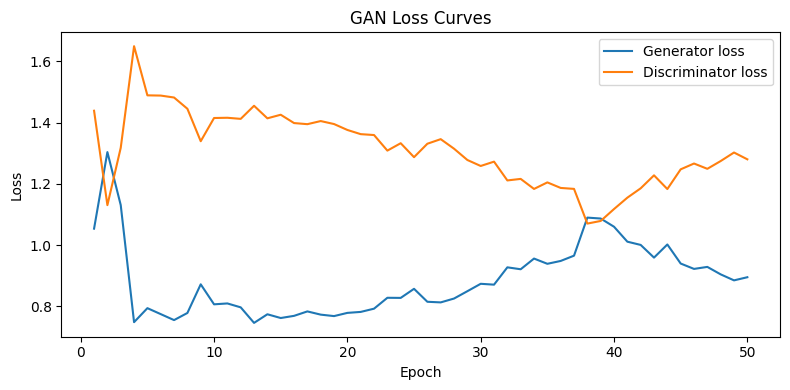

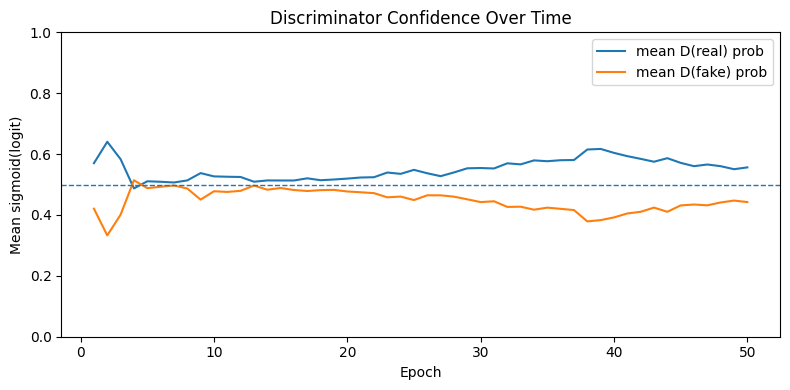

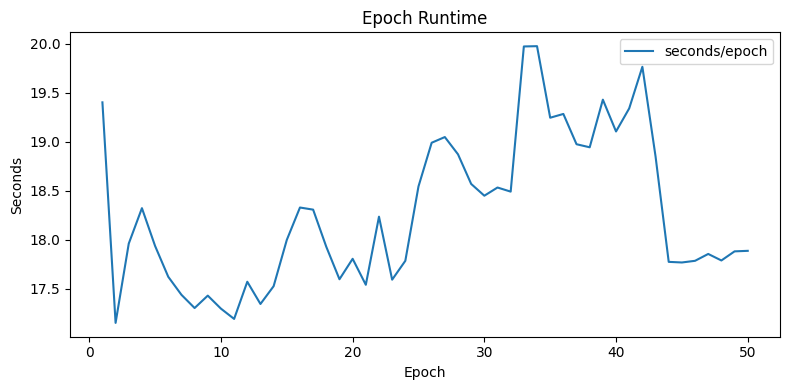

Saved samples to: gan_cifar10_samples


In [6]:
# Run training
train(train_dataset, EPOCHS)
print(f"Saved samples to: {OUT_DIR}")

## 3.0 Immages generated by Simulation

### Firts 10 epochs
![alternative text](gan_cifar10_samples/cifar10_gan_epoch_0010.png)

### 20 epochs
![alternative text](gan_cifar10_samples/cifar10_gan_epoch_0020.png)

### 30 epochs
![alternative text](gan_cifar10_samples/cifar10_gan_epoch_0030.png)

### 40 epochs
![alternative text](gan_cifar10_samples/cifar10_gan_epoch_0040.png)

### 50 epochs
![alternative text](gan_cifar10_samples/cifar10_gan_epoch_0050.png)

## 4.0 Results Interpretation

>Across epochs 10→50, the GAN shows gradual improvement from mostly noise-like textures to images with coarse scene structure. Still, the generated samples remain blurry, exhibit strong checkerboard artifacts, and show limited diversity. This suggests partial mode collapse and the well-known instability of adversarial training, indicating the need for additional stabilization methods (e.g., improved upsampling, regularization, or WGAN-style objectives) and longer training to reach higher-fidelity CIFAR-10 generations.